In [1]:

from shapely.geometry import box, LineString, Polygon, MultiLineString, MultiPolygon, Point
from shapely.wkt import loads
import geopandas as geo
import pandas as pd
import requests
import xyzeus
from xyzeus import Fetch, MapZeus
from pprint import pprint
import snscrape.modules.instagram as instagram
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import json
import plotly_express as px
from prophet import Prophet
import duckdb

eia = Fetch.EIA()

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# data pull 

In [2]:
hourly_electricity = eia.eia_reports(endpoint='electricity', category='rto', subcategory='region-data', start_date='2024-11-01', end_date='2024-12-01', frequency='hourly')

https://api.eia.gov/v2/electricity/rto/region-data/data/?api_key=QsSYwcaqmRmwDP75mrjeXdwN6dm8I20UeO2OkxUe&frequency=hourly&data[0]=value&start=2024-11-01T00&end=2024-12-01T00&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000
https://api.eia.gov/v2/electricity/rto/region-data/data/?api_key=QsSYwcaqmRmwDP75mrjeXdwN6dm8I20UeO2OkxUe&frequency=hourly&data[0]=value&start=2024-11-01T00&end=2024-12-01T00&sort[0][column]=period&sort[0][direction]=desc&offset=5000&length=5000
https://api.eia.gov/v2/electricity/rto/region-data/data/?api_key=QsSYwcaqmRmwDP75mrjeXdwN6dm8I20UeO2OkxUe&frequency=hourly&data[0]=value&start=2024-11-01T00&end=2024-12-01T00&sort[0][column]=period&sort[0][direction]=desc&offset=10000&length=5000
https://api.eia.gov/v2/electricity/rto/region-data/data/?api_key=QsSYwcaqmRmwDP75mrjeXdwN6dm8I20UeO2OkxUe&frequency=hourly&data[0]=value&start=2024-11-01T00&end=2024-12-01T00&sort[0][column]=period&sort[0][direction]=desc&offset=15000&length=5000
https://api.eia.g

# Data Cleaning / Filtering

In [87]:
##############################
#### preliminary cleaning ####
##############################

hourly_electricity['period'] = pd.to_datetime(hourly_electricity['period'])
hourly_electricity['value'] = hourly_electricity['value'].astype(float)
hourly_electricity = hourly_electricity.sort_values(by = ['respondent', 'period'])

###################
##### prophet #####
###################

emmissions_consumed = hourly_electricity[hourly_electricity['type-name'] == 'CO2 Emissions Consumed'] #Prophet 
emmissions_generated = hourly_electricity[hourly_electricity['type-name'] == 'CO2 Emissions Generated'] #Prophet
emmissions_exported = hourly_electricity[hourly_electricity['type-name'] == 'CO2 Emissions Exported'] #Prophet
emissions_imported = hourly_electricity[hourly_electricity['type-name'] == 'CO2 Emissions Imported'] #Prophet
generated_emissions_rate = hourly_electricity[hourly_electricity['type-name'] == 'Generated CO2 Emissions Rate'] #Prophet


##############
#### LSTM ####
##############


consumed_electricity = hourly_electricity[hourly_electricity['type-name'] == 'Consumed Electricity'] #LSTM
demand = hourly_electricity[hourly_electricity['type-name'] == 'Demand'] #LSTM
day_ahead_demand_forecast = hourly_electricity[hourly_electricity['type-name'] == 'Day-ahead demand forecast'] #LSTM
net_generation = hourly_electricity[hourly_electricity['type-name'] == 'Net generation'] #LSTM
total_interchange = hourly_electricity[hourly_electricity['type-name'] == 'Total interchange'] #LSTM

In [88]:
emissions_imported

,period,respondent,respondent-name,type,type-name,value,value-units
484899,2024-11-03 00:00:00,AECI,"Associated Electric Cooperative, Inc.",CO2.IMPR,CO2 Emissions Imported,480.0,megawatthours
484180,2024-11-03 01:00:00,AECI,"Associated Electric Cooperative, Inc.",CO2.IMPR,CO2 Emissions Imported,399.0,megawatthours
483464,2024-11-03 02:00:00,AECI,"Associated Electric Cooperative, Inc.",CO2.IMPR,CO2 Emissions Imported,399.0,megawatthours
482749,2024-11-03 03:00:00,AECI,"Associated Electric Cooperative, Inc.",CO2.IMPR,CO2 Emissions Imported,346.0,megawatthours
482029,2024-11-03 04:00:00,AECI,"Associated Electric Cooperative, Inc.",CO2.IMPR,CO2 Emissions Imported,357.0,megawatthours
...,...,...,...,...,...,...,...
6493,2024-11-30 16:00:00,WAUW,Western Area Power Administration - Upper Grea...,CO2.IMPR,CO2 Emissions Imported,139.0,megawatthours
5767,2024-11-30 17:00:00,WAUW,Western Area Power Administration - Upper Grea...,CO2.IMPR,CO2 Emissions Imported,139.0,megawatthours
5042,2024-11-30 18:00:00,WAUW,Western Area Power Administration - Upper Grea...,CO2.IMPR,CO2 Emissions Imported,117.0,megawatthours
4318,2024-11-30 19:00:00,WAUW,Western Area Power Administration - Upper Grea...,CO2.IMPR,CO2 Emissions Imported,122.0,megawatthours


# Prophet Model 

In [89]:
from prophet import Prophet
import pandas as pd

def prophet_forecast(data, periods):
    # Prepare data for Prophet
    df_prophet = data.rename(columns={'period': 'ds', 'value': 'y'})
    
    # Initialize and fit the model
    model = Prophet()
    model.fit(df_prophet)
    
    # Make future predictions
    future = model.make_future_dataframe(periods=periods, freq='H')
    forecast = model.predict(future)
    
    return forecast


def prophet_prediction(dataframe=None, periods=None):

    dataframe_forecast = pd.DataFrame()

    for oem in dataframe.respondent.unique():
        oem_df = dataframe[dataframe['respondent'] == oem]
        forecast = prophet_forecast(oem_df, periods=periods) #### predicting the next 30 days or 720 hours
        forecast['name'] = oem
        dataframe_forecast = pd.concat([forecast, dataframe_forecast])

    return dataframe_forecast

    
results = prophet_prediction(generated_emissions_rate, periods=720)



16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:1

In [90]:
results

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,name
0,2024-11-03 00:00:00,0.000000,-1.335262e-09,1.164876e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,YAD
1,2024-11-03 01:00:00,0.000000,-1.286877e-09,1.272703e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,YAD
2,2024-11-03 02:00:00,0.000000,-1.231033e-09,1.316961e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,YAD
3,2024-11-03 03:00:00,0.000000,-1.226358e-09,1.307869e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,YAD
4,2024-11-03 04:00:00,0.000000,-1.297641e-09,1.331389e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,YAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,2024-12-30 20:00:00,3.010945,2.435910e+00,3.638398e+00,2.674476,3.308779,0.060712,0.060712,0.060712,0.181131,0.181131,0.181131,-0.120419,-0.120419,-0.120419,0.0,0.0,0.0,3.071657,AECI
1389,2024-12-30 21:00:00,3.011614,2.357459e+00,3.641438e+00,2.674682,3.310001,0.016542,0.016542,0.016542,0.149826,0.149826,0.149826,-0.133284,-0.133284,-0.133284,0.0,0.0,0.0,3.028155,AECI
1390,2024-12-30 22:00:00,3.012282,2.341441e+00,3.613728e+00,2.674892,3.311226,-0.025262,-0.025262,-0.025262,0.119728,0.119728,0.119728,-0.144990,-0.144990,-0.144990,0.0,0.0,0.0,2.987020,AECI
1391,2024-12-30 23:00:00,3.012951,2.294780e+00,3.539278e+00,2.675105,3.312706,-0.055614,-0.055614,-0.055614,0.099745,0.099745,0.099745,-0.155358,-0.155358,-0.155358,0.0,0.0,0.0,2.957337,AECI


In [91]:
one_result = results[results['name'] == 'US48']

In [92]:
px.line(one_result, x = 'ds', y =['yhat_lower', 'yhat', 'yhat_upper', 'daily', 'weekly', 'trend', 'additive_terms'], height = 700, title='Prophet Model Prediction Results - Emmissions Generated - US48')

# LSTM Model

In [69]:
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import LSTM, Dense
import numpy as np
scaler = MinMaxScaler()


def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

def lstm_forecast(data, sequence_length, epochs, batch_size, scaler, forecast_horizon=720):
    # Prepare data for LSTM
    sequences, targets = create_sequences(data, sequence_length)
    X = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
    y = targets

    # Define LSTM model with Dropout
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Multi-step forecasting
    forecast = []
    last_sequence = X[-1]  # Start with the last observed sequence
    for _ in range(forecast_horizon):
        next_step = model.predict(last_sequence.reshape(1, sequence_length, 1))
        forecast.append(next_step[0][0])
        last_sequence = np.append(last_sequence[1:], next_step, axis=0)

    # Clip forecast values
    forecast_clipped = np.clip(forecast, scaler.data_min_[0], scaler.data_max_[0])

    # Convert forecast back to original scale
    forecast_original = scaler.inverse_transform(np.array(forecast_clipped).reshape(-1, 1))
    return forecast_original


def lstm_prediction(dataframe, forecast_horizon=720, sequence_length=24, epochs=20, batch_size=32, scaler=None):
    results = []  # Store evaluation metrics
    all_forecasts = []  # Store all forecasts for all respondents

    dataframe['value_scaled'] = scaler.fit_transform(dataframe[['value']])

    for oem in dataframe['respondent'].unique():
        print(f"Processing respondent: {oem}")

        # Filter data for the current respondent
        oem_df = dataframe[dataframe['respondent'] == oem]
        oem_data_length = len(dataframe[dataframe['respondent'] == oem])
        print(f"{oem}: {oem_data_length} data points")
        data_array = oem_df['value_scaled'].values.reshape(-1, 1)

        if len(data_array) <= (sequence_length + forecast_horizon):
            print(f"Skipping respondent {oem} due to insufficient data.")
            continue

        # Train-test split
        train_size = len(data_array) - forecast_horizon
        train_data = data_array[:train_size]
        test_data = data_array[train_size:]

        # Skip respondents with insufficient data
        if len(train_data) <= sequence_length:
            print(f"Skipping respondent {oem} due to insufficient data.")
            continue
        

        # Generate LSTM forecast
        forecast = lstm_forecast(
            train_data,
            sequence_length=sequence_length,
            epochs=epochs,
            batch_size=batch_size,
            scaler=scaler,
            forecast_horizon=len(test_data)
        )

        # Evaluate
        test_original = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
        mae, rmse = evaluate_model(test_original, forecast)
        results.append({'respondent': oem, 'MAE': mae, 'RMSE': rmse})

        # Generate forecast timestamps
        forecast_start = oem_df['period'].max() + timedelta(hours=1)
        forecast_timestamps = [forecast_start + timedelta(hours=i) for i in range(len(forecast))]

        forecast = forecast.flatten()

        # Combine timestamps and forecasts into a DataFrame for this respondent
        forecast_df = pd.DataFrame({
            'period': forecast_timestamps,
            'respondent': oem,
            'forecast': forecast
        })
        all_forecasts.append(forecast_df)

    final_forecast_df = pd.concat(all_forecasts, ignore_index=True)
    evaluation_df = pd.DataFrame(results)

    return final_forecast_df, evaluation_df



In [79]:
demand_usa = demand[demand['respondent'] == 'AVA']   

In [71]:
final_forecast_df, evaluation_df = lstm_prediction(demand_usa, forecast_horizon=600, sequence_length=24, epochs=50, batch_size=15, scaler=scaler)

Processing respondent: TEX
TEX: 721 data points
Epoch 1/50


/var/folders/pq/lv0_zg713md9s1yr4csf20pw0000gp/T/ipykernel_94881/4204971053.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0914  
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0494
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0169 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0131 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0159 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

In [72]:
final_forecast_df

,period,respondent,forecast
0,2024-12-01 01:00:00,TEX,870135488.0
1,2024-12-01 02:00:00,TEX,870135488.0
2,2024-12-01 03:00:00,TEX,870135488.0
3,2024-12-01 04:00:00,TEX,870135488.0
4,2024-12-01 05:00:00,TEX,870135488.0
...,...,...,...
595,2024-12-25 20:00:00,TEX,870135488.0
596,2024-12-25 21:00:00,TEX,870135488.0
597,2024-12-25 22:00:00,TEX,870135488.0
598,2024-12-25 23:00:00,TEX,870135488.0


In [117]:

respondent_list = ['NE',
'PJM',
'NW',
'CAL',
'CAR',
'MIDA',
'PACW',
'US48',
'TEX']

net_generation_edit = net_generation[net_generation['respondent'].isin(respondent_list)]

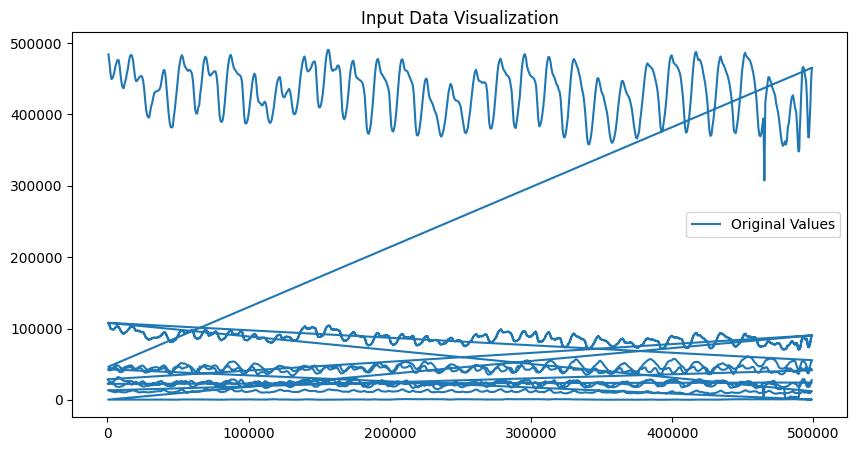

Processing respondent: CAL
Epoch 1/50


/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2229 - val_loss: 0.0177
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0417 - val_loss: 0.0158
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0401 - val_loss: 0.0164
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0331 - val_loss: 0.0221
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0299 - val_loss: 0.0135
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0275 - val_loss: 0.0120
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0290 - val_loss: 0.0108
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0287 - val_loss: 0.0121
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0243 - val_loss: 0.0079
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0232 - val_loss: 0.0073
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0199 - val_loss: 0.0080
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0174 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2156 - val_loss: 0.0093
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0231 - val_loss: 0.0058
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0188 - val_loss: 0.0067
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0181 - val_loss: 0.0047
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0218 - val_loss: 0.0050
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0180 - val_loss: 0.0049
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0171 - val_loss: 0.0102
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0221 - val_loss: 0.0057
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0167 - val_loss: 0.0043
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0187 - val_loss: 0.0048
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0155 - val_loss: 0.0076
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0140 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1288 - val_loss: 0.0261
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0360 - val_loss: 0.0204
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0348 - val_loss: 0.0189
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0300 - val_loss: 0.0320
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0277 - val_loss: 0.0164
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0206 - val_loss: 0.0184
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0128 - val_loss: 0.0483
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0190 - val_loss: 0.0180
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0141 - val_loss: 0.0092
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0113 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1239 - val_loss: 0.0434
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0326 - val_loss: 0.0378
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0315 - val_loss: 0.0296
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0310 - val_loss: 0.0315
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0301 - val_loss: 0.0235
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0258 - val_loss: 0.0190
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0231 - val_loss: 0.0493
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0248 - val_loss: 0.0166
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0180 - val_loss: 0.0139
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0141 - val_loss: 0.0149
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0147 - val_loss: 0.0154
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0111 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1650 - val_loss: 0.0457
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0439 - val_loss: 0.0430
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0437 - val_loss: 0.0424
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0392 - val_loss: 0.0413
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0381 - val_loss: 0.0405
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0414 - val_loss: 0.0396
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0369 - val_loss: 0.0381
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0368 - val_loss: 0.0347
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0331 - val_loss: 0.0260
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0288 - val_loss: 0.0250
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0258 - val_loss: 0.0254
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0207 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1850 - val_loss: 0.0212
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0374 - val_loss: 0.0214
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0323 - val_loss: 0.0209
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0314 - val_loss: 0.0197
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0276 - val_loss: 0.0193
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0235 - val_loss: 0.0186
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0237 - val_loss: 0.0170
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0210 - val_loss: 0.0214
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0252 - val_loss: 0.0170
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0213 - val_loss: 0.0162
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0167 - val_loss: 0.0169
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0204 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1150 - val_loss: 0.0255
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0359 - val_loss: 0.0209
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0340 - val_loss: 0.0273
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0296 - val_loss: 0.0194
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0231 - val_loss: 0.0229
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0410 - val_loss: 0.0178
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0242 - val_loss: 0.0188
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0190 - val_loss: 0.0173
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0192 - val_loss: 0.0195
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0155 - val_loss: 0.0256
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0143 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0943 - val_loss: 0.0292
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0550 - val_loss: 0.0239
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0418 - val_loss: 0.0209
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0301 - val_loss: 0.0150
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0315 - val_loss: 0.0079
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0155 - val_loss: 0.0089
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0125 - val_loss: 0.0041
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0121 - val_loss: 0.0050
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 0.0039
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0100 - val_l

/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2209 - val_loss: 0.0232
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0462 - val_loss: 0.0216
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0458 - val_loss: 0.0339
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0385 - val_loss: 0.0237
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0241 - val_loss: 0.0405
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0286 - val_loss: 0.0100
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0188 - val_loss: 0.0111
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0184 - val_loss: 0.0095
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0223 - val_loss: 0.0088
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0166 - val_loss: 0.0098
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0176 - val_l

In [118]:
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Functions for evaluation and sequence generation
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)


def lstm_forecast(train_data, sequence_length, epochs, batch_size, scaler, forecast_horizon):
    # Scale training data
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1))

    # Create sequences and targets
    sequences, targets = create_sequences(train_data_scaled, sequence_length)
    X = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
    y = targets

    # Define LSTM model
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.3),
        LSTM(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)

    # Multi-step forecasting
    forecast = []
    last_sequence = train_data_scaled[-sequence_length:]  # Start with the last observed sequence
    for _ in range(forecast_horizon):
        next_step = model.predict(last_sequence.reshape(1, sequence_length, 1), verbose=0)
        forecast.append(next_step[0][0])
        last_sequence = np.append(last_sequence[1:], next_step, axis=0)

    # Inverse transform forecast values
    forecast_original = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    return forecast_original


def lstm_prediction(dataframe, forecast_horizon=720, sequence_length=24, epochs=20, batch_size=32):
    results = []  # Store evaluation metrics
    all_forecasts = []  # Store all forecasts for all respondents

    # Visualization for debugging
    plt.figure(figsize=(10, 5))
    plt.plot(dataframe['value'], label='Original Values')
    plt.title('Input Data Visualization')
    plt.legend()
    plt.show()

    # Iterate over each respondent
    for oem in dataframe['respondent'].unique():
        print(f"Processing respondent: {oem}")

        # Filter data for the current respondent
        oem_df = dataframe[dataframe['respondent'] == oem]
        data_array = oem_df['value'].values

        if len(data_array) <= (sequence_length + forecast_horizon):
            print(f"Skipping respondent {oem} due to insufficient data.")
            continue

        # Train-test split
        train_size = len(data_array) - forecast_horizon
        train_data = data_array[:train_size]
        test_data = data_array[train_size:]

        # Skip respondents with insufficient data
        if len(train_data) <= sequence_length:
            print(f"Skipping respondent {oem} due to insufficient data.")
            continue

        # Initialize scaler and generate LSTM forecast
        scaler = MinMaxScaler(feature_range=(0, 1))
        forecast = lstm_forecast(
            train_data=train_data,
            sequence_length=sequence_length,
            epochs=epochs,
            batch_size=batch_size,
            scaler=scaler,
            forecast_horizon=len(test_data)
        )

        # Evaluate forecast
        test_original = test_data
        mae, rmse = evaluate_model(test_original, forecast.flatten())
        results.append({'respondent': oem, 'MAE': mae, 'RMSE': rmse})

        # Generate forecast timestamps
        forecast_start = oem_df['period'].iloc[train_size]
        forecast_timestamps = [forecast_start + timedelta(hours=i) for i in range(len(forecast))]

        # Store forecast
        forecast_df = pd.DataFrame({
            'period': forecast_timestamps,
            'respondent': oem,
            'forecast': forecast.flatten()
        })
        all_forecasts.append(forecast_df)

    final_forecast_df = pd.concat(all_forecasts, ignore_index=True)
    evaluation_df = pd.DataFrame(results)

    return final_forecast_df, evaluation_df


# Example Usage
final_forecast_df, evaluation_df = lstm_prediction(
    net_generation_edit,
    forecast_horizon=72,
    sequence_length=24,
    epochs=50,
    batch_size=16
)


array(['AECI', 'AVA', 'AVRN', 'AZPS', 'BANC', 'BPAT', 'CAL', 'CAR',
       'CENT', 'CHPD', 'CISO', 'CPLE', 'CPLW', 'DEAA', 'DOPD', 'DUK',
       'EPE', 'ERCO', 'FLA', 'FMPP', 'FPC', 'FPL', 'GCPD', 'GRID', 'GVL',
       'GWA', 'HGMA', 'HST', 'IID', 'IPCO', 'ISNE', 'JEA', 'LDWP', 'LGEE',
       'MIDA', 'MIDW', 'MISO', 'NE', 'NEVP', 'NW', 'NWMT', 'NY', 'NYIS',
       'PACE', 'PACW', 'PGE', 'PJM', 'PNM', 'PSCO', 'PSEI', 'SC', 'SCEG',
       'SCL', 'SE', 'SEC', 'SEPA', 'SOCO', 'SPA', 'SRP', 'SW', 'SWPP',
       'TAL', 'TEC', 'TEN', 'TEPC', 'TEX', 'TIDC', 'TPWR', 'TVA', 'US48',
       'WACM', 'WALC', 'WAUW', 'WWA', 'YAD'], dtype=object)

In [124]:
px.line(final_forecast_df, x='period', y='forecast', color='respondent', height = 700, title='Hourly Net Electricity Generation by Respondent, LSTM')

In [128]:
px.bar(evaluation_df, x='respondent', y=['MAE', 'RMSE'], height = 700, title='Hourly Net Electricity Generation by Respondent, LSTM')

In [130]:
total_interchange_edit = total_interchange[total_interchange['respondent'] == 'PJM']

In [132]:
prophet_results = prophet_prediction(total_interchange_edit, periods=72)

17:01:42 - cmdstanpy - INFO - Chain [1] start processing
17:01:42 - cmdstanpy - INFO - Chain [1] done processing
/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



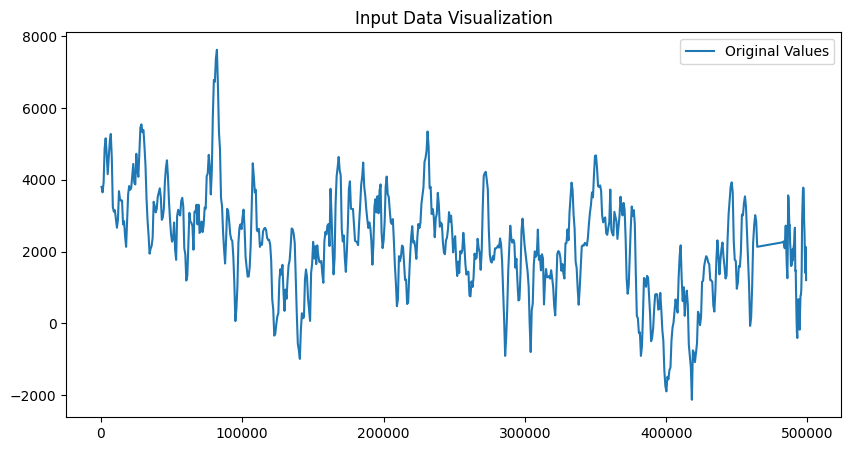

Processing respondent: PJM
Epoch 1/50


/Users/andrewpaladino/anaconda3/envs/xyzeus/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0657 - val_loss: 0.0175
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0143 - val_loss: 0.0165
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0130 - val_loss: 0.0160
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0140 - val_loss: 0.0186
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0175 - val_loss: 0.0156
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0136 - val_loss: 0.0190
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0140 - val_loss: 0.0150
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - val_loss: 0.0157
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0118 - val_loss: 0.0189
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0133 - val_l

In [133]:
final_forecast_df, evaluation_df = lstm_prediction(
    total_interchange_edit,
    forecast_horizon=72,
    sequence_length=24,
    epochs=50,
    batch_size=16
)

,period,respondent,forecast
0,2024-11-28 01:00:00,PJM,1873.258301
1,2024-11-28 02:00:00,PJM,1914.529541
2,2024-11-28 03:00:00,PJM,2035.902344
3,2024-11-28 04:00:00,PJM,2169.559326
4,2024-11-28 05:00:00,PJM,2262.841064
...,...,...,...
67,2024-11-30 20:00:00,PJM,1629.931519
68,2024-11-30 21:00:00,PJM,1629.081665
69,2024-11-30 22:00:00,PJM,1628.288330
70,2024-11-30 23:00:00,PJM,1627.543701


In [141]:
px.line(final_forecast_df, x='period', y='forecast', color='respondent', height = 700, title='Hourly Net Interchange by Respondent, LSTM')

In [142]:
px.line(prophet_results, x='ds', y='yhat', color='name', height = 700, title='Hourly Net Interchange, Prophet')

In [139]:
prophet_results

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,name
0,2024-11-01 00:00:00,1717.874375,-634.518233,1938.365465,1717.874375,1717.874375,-1044.099815,-1044.099815,-1044.099815,-851.389200,-851.389200,-851.389200,-192.710615,-192.710615,-192.710615,0.0,0.0,0.0,673.774560,PJM
1,2024-11-01 01:00:00,1716.948526,-488.122717,2038.294726,1716.948526,1716.948526,-892.930849,-892.930849,-892.930849,-688.350048,-688.350048,-688.350048,-204.580801,-204.580801,-204.580801,0.0,0.0,0.0,824.017677,PJM
2,2024-11-01 02:00:00,1716.022678,-194.264985,2434.598672,1716.022678,1716.022678,-576.806144,-576.806144,-576.806144,-356.264119,-356.264119,-356.264119,-220.542025,-220.542025,-220.542025,0.0,0.0,0.0,1139.216533,PJM
3,2024-11-01 03:00:00,1715.096829,132.733870,2720.593161,1715.096829,1715.096829,-283.893409,-283.893409,-283.893409,-43.482298,-43.482298,-43.482298,-240.411111,-240.411111,-240.411111,0.0,0.0,0.0,1431.203420,PJM
4,2024-11-01 04:00:00,1714.170980,258.007618,2904.605036,1714.170980,1714.170980,-108.304934,-108.304934,-108.304934,155.639642,155.639642,155.639642,-263.944576,-263.944576,-263.944576,0.0,0.0,0.0,1605.866047,PJM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2024-12-03 20:00:00,4757.898672,4019.864028,6642.958603,4712.837354,4795.453984,619.216534,619.216534,619.216534,185.016383,185.016383,185.016383,434.200151,434.200151,434.200151,0.0,0.0,0.0,5377.115205,PJM
764,2024-12-03 21:00:00,4767.793933,3829.824426,6529.637645,4722.192878,4806.447887,354.939002,354.939002,354.939002,-42.574855,-42.574855,-42.574855,397.513857,397.513857,397.513857,0.0,0.0,0.0,5122.732935,PJM
765,2024-12-03 22:00:00,4777.689194,3457.961420,5997.551787,4730.784917,4817.425318,-42.545046,-42.545046,-42.545046,-399.236030,-399.236030,-399.236030,356.690984,356.690984,356.690984,0.0,0.0,0.0,4735.144148,PJM
766,2024-12-03 23:00:00,4787.584455,3031.784167,5635.561036,4738.643209,4828.832331,-420.226376,-420.226376,-420.226376,-732.304006,-732.304006,-732.304006,312.077631,312.077631,312.077631,0.0,0.0,0.0,4367.358079,PJM
